# Import libraries and data

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import re

In [130]:
# Read in data and inspect
df = pd.read_csv('superstore_data.csv')


#df.head(3)
#df.columns
#df.describe()

# Data Cleanliness

#### Check for null values

In [131]:
# Return any rows with null values
df.loc[df.isna().any(axis = 1)]


# No null values within dataset

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit


#### Remove unecessary data

In [132]:
# Row ID not needed as dataframe is indexed
df.drop(['Row ID'], inplace = True, axis = 1)


# We are aiming to analyse only consumer behaviour, dropping corporate and home office sales
df['Segment'].unique()
df_cons = df.loc[df['Segment'] == 'Consumer']


df_cons.head(3)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310


# 1) Postal Data

#### Prep data for analysis

In [133]:
# Select data necessary for question, will be using standard class delivery for analysis
df_post = df_cons.loc[df_cons['Ship Mode'] == 'Standard Class'][['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'State']]


# Check date columns are in datetime format
df_post.dtypes  # Must convert to datetime


# Convert to datetime
df_post['Ship Date'] = pd.to_datetime(df_post['Ship Date'])
df_post['Order Date'] = pd.to_datetime(df_post['Order Date'])


# Check the datatype has changed as necessary
df_post.dtypes


df_post.head(3)

,Order ID,Order Date,Ship Date,Ship Mode,State
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,Florida
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,Florida
5,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,California


#### Analysis

In [150]:
# Create Delivery time collumn as the days taken, set to integers
df_post['Delivery Time'] = (df_post['Ship Date'] - df_post['Order Date']).astype('str').apply(lambda x: x.split(' ')[0]).astype('int32')


# Drop repeat order id's to get unique deliveries
df_post = df_post.drop_duplicates(subset = 'Order ID')

len(df_post)


# Find average delivery time by state
delivery_time = df_post.groupby('State').mean().round(1)['Delivery Time'].to_frame('Avg Standard Delivery').reset_index()
delivery_time.head(3)

,State,Avg Standard Delivery
0,Alabama,5.1
1,Arizona,5.1
2,Arkansas,5.5


#### Export data for visualisation

In [135]:
delivery_time.to_csv('delivery_time.csv')

## Addition of data for further analysis

In [136]:
# Find the average year of each order to be used as the time period for sourcing further data
df_post['Year'] = df_post['Order Date'].dt.year
df_post['Year'].mean().round(0)

# In reality is difficult to find all necessary data from 2016

2016.0

#### Read in additional information and merge dataframes

In [137]:
states = pd.read_csv('state_information.csv')


# Merge datasets and drop null values. Values sorted for matplotlib visualisation
merged = pd.merge(delivery_time, states, how = 'left', left_on = 'State', right_on = 'State').dropna(how = 'any').sort_values('POs per 100,000 People')
merged.head(3)

,State,Avg Standard Delivery,Number of Post Offices,Population,"POs per 100,000 People"
8,Florida,5.2,750.0,21477737.0,3.5
1,Arizona,5.1,265.0,7278717.0,3.6
3,California,5.0,1634.0,39512223.0,4.1


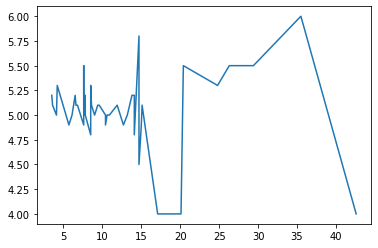

In [138]:
# Use matplotlib to quickly assess relationships prior to using Tableu
# A more detailed graph with nice formatting could be used but is not necessary as final visualisation is in tableu

x = merged['POs per 100,000 People']
y = merged['Avg Standard Delivery']

plt.plot(x,y)
plt.show()

#### Export for visualisation

In [139]:
merged.to_csv('states_correlations.csv')

# 2) Products

## 2a) Find the top 10 sub-categories for average time between purchases for repeat purchasers. Use all sub-categories for visualisation.

#### Data Preperation

In [140]:
# Select the relevant collumns and change necessary datatypes
df_rep = df_cons[['Order ID', 'Customer ID', 'Order Date', 'Sub-Category', 'Category']]
df_rep['Order Date'] = pd.to_datetime(df_rep['Order Date'])


# Select only unique orders
df_rep = df_rep.drop_duplicates(subset = 'Order ID').sort_values(['Customer ID', 'Order Date'], ascending = [True, True])


# Create a collumn with the previous order date and drop the first order by each customer
df_rep['Previous Order Date'] = df_rep.groupby('Customer ID')['Order Date'].shift(1)
df_rep.dropna(how = 'any', inplace = True)


# Calculate the time difference collumn 
df_rep['Time Difference'] = (df_rep['Order Date'] - df_rep['Previous Order Date']).astype('str').apply(lambda x: x.split(' ')[0]).astype('int32')
df_rep.head(5)

/var/folders/gx/s7xsfs7d331bdyr5z5jpbk1w0000gn/T/ipykernel_72629/4220029809.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep['Order Date'] = pd.to_datetime(df_rep['Order Date'])


,Order ID,Customer ID,Order Date,Sub-Category,Category,Previous Order Date,Time Difference
7468,CA-2014-138100,AA-10315,2014-09-15,Paper,Office Supplies,2014-03-31,168
1299,CA-2015-121391,AA-10315,2015-10-04,Storage,Office Supplies,2014-09-15,384
5198,CA-2016-103982,AA-10315,2016-03-03,Supplies,Office Supplies,2015-10-04,151
1159,CA-2017-147039,AA-10315,2017-06-29,Appliances,Office Supplies,2016-03-03,483
3007,CA-2014-130729,AA-10375,2014-10-24,Binders,Office Supplies,2014-04-21,186


#### Analysis

In [141]:
# Find average time difference for each sub-category
sub_time = df_rep.groupby('Sub-Category').mean().astype('int32')['Time Difference'].to_frame('Avg Time Between Purchases').reset_index()


# Create a collumn ranking the times in decsending order
sub_time['Rank'] = sub_time['Avg Time Between Purchases'].rank(method = 'min', ascending = False)


# Order the rows by rank
sub_rank = sub_time.sort_values('Rank')


# Create a dataframe with the corresponding category for each sub category
sub_to_cat = df_rep[['Sub-Category', 'Category']].drop_duplicates()


In [142]:
# Add the corresponding category onto table for potential visualisation
sub_merged = pd.merge(sub_rank, sub_to_cat, how = 'left', left_on = 'Sub-Category', right_on = 'Sub-Category')


# Output the top 10 ranked sub-categories
sub_merged.loc[sub_merged['Rank'] <= 10]

,Sub-Category,Avg Time Between Purchases,Rank,Category
0,Machines,228,1.0,Technology
1,Tables,205,2.0,Furniture
2,Paper,205,2.0,Office Supplies
3,Furnishings,204,4.0,Furniture
4,Art,196,5.0,Office Supplies
5,Binders,193,6.0,Office Supplies
6,Bookcases,190,7.0,Furniture
7,Copiers,190,7.0,Technology
8,Storage,185,9.0,Office Supplies
9,Phones,184,10.0,Technology


#### Export data for visualisation

In [143]:
sub_merged.to_csv('repeat_purchases.csv')

## 2b) Proportion of discounted orders above 50% that belong to each sub-category

In [144]:
# Obtain necessary collumns with unique orders
df_dis = df_cons[['Order ID', 'Category', 'Sub-Category', 'Discount']].drop_duplicates(subset = 'Order ID')


# Obtain all rows with 50% discount rate or greater
sub_count = df_dis.loc[df_dis['Discount'] >= 0.5].groupby(['Category', 'Sub-Category']).count()['Order ID'].to_frame('Count').reset_index()


sub_count

,Category,Sub-Category,Count
0,Furniture,Bookcases,12
1,Furniture,Furnishings,36
2,Furniture,Tables,15
3,Office Supplies,Appliances,23
4,Office Supplies,Binders,173
5,Technology,Machines,6


#### Export for Visualisation

In [145]:
sub_count.to_csv('subcat_count.csv')

## 2c) Most popular item colours

In [146]:
# Set colours to serach for 
colours = ['Blue', 'Red', 'Gold', 'Silver', 'Orange', 'Yellow', 'Gray',
          'Orange', 'Green', 'Purple', 'Pink', 'Black']


# Define empty lists
col = []
quant = []


# Loop through colours, appending each colour and the quantity into the empty lists
for colour in colours:
    count = len(df_cons.loc[df_cons['Product Name'].str.contains(colour, flags = re.I, regex = True)])
    col.append(colour)
    quant.append(count)


# Create a new dataframe with the full lists
col_count = pd.DataFrame(data = {'Colour' : col, 'Count' : quant})


col_count

,Colour,Count
0,Blue,104
1,Red,141
2,Gold,12
3,Silver,9
4,Orange,6
5,Yellow,13
6,Gray,64
7,Orange,6
8,Green,17
9,Purple,1


#### Export for data visualisation

In [147]:
col_count.to_csv('colour_quantities.csv')

#### Further code for analysis

In [148]:
# Output Sub-Categories available at different discounts
df_cons.loc[df_cons['Discount'] == 0.5]['Sub-Category'].unique()

array(['Bookcases', 'Tables', 'Machines'], dtype=object)

In [149]:
# Find the average cost of each Sub-Category
df_cons['Cost'] = df_cons['Sales']/df_cons['Quantity']
df_cons.groupby('Sub-Category').mean()['Cost'].reset_index()

/var/folders/gx/s7xsfs7d331bdyr5z5jpbk1w0000gn/T/ipykernel_72629/1375204296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cons['Cost'] = df_cons['Sales']/df_cons['Quantity']


,Sub-Category,Cost
0,Accessories,55.903299
1,Appliances,58.256025
2,Art,8.894921
3,Binders,39.216497
4,Bookcases,134.259070
5,Chairs,136.363003
6,Copiers,591.991943
7,Envelopes,19.096729
8,Fasteners,3.436105
9,Furnishings,26.821024
